# CLIP + Self-Attention for Fine-Grained Hate-Meme Detection  
End-to-end pipeline: 25 hate-categories × 9 prompts → CLIP features → Self-Attention classifier → Optuna tuning → Ablation & error analysis
CLIP (ViT-L/14) + Self-Attention Classifier – with precision, recall, & hyper-parameter tuning.


## Environment Setup  
Install once, then import all libraries we’ll need for CLIP, training, tuning, plotting and graceful interrupts.

In [2]:
# Install required packages (run once in your environment)
# --------------- CELL 1 : ENVIRONMENT --------------------------------------
!pip install -q ftfy regex tqdm git+https://github.com/openai/CLIP.git \
                seaborn scikit-learn optuna optuna-dashboard joblib

# --------------- CELL 2 : IMPORTS ------------------------------------------
import os, sys, torch, clip, numpy as np, pandas as pd, torch.nn as nn, optuna, joblib
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score,
                             precision_score, recall_score, confusion_matrix,
                             precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import signal, hashlib, pickle
from contextlib import contextmanager

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

/tmp/ipykernel_3660278/1090704709.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import os, sys, torch, clip, numpy as np, pandas as pd, torch.nn as nn, optuna, joblib
/usr/local/pace-apps/manual/packages/anaconda3/2023.03/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [3]:
import sys
print(sys.executable)

/usr/local/pace-apps/manual/packages/anaconda3/2023.03/bin/python


Get the data from the google drive. You need to update this based on where your data is in the google drive

In [ ]:
# Don't use this if using PACE
from google.colab import drive
drive.mount('/content/drive')


## Dataset & Prompt Engineering  
We design **25 specific hate concepts** and **9 prompt templates per concept** → 225 natural-language queries that CLIP will align to image content.  
Update `DATA_ROOT` for PACE (or Colab).

In [4]:
# PACE setup — update accordingly
DATA_ROOT  = '/home/hice1/gdangi3/scratch/data'   # <-- change if needed
CACHE_DIR  = '/home/hice1/gdangi3/scratch/clip_cache'
os.makedirs(CACHE_DIR, exist_ok=True)

train_df = pd.read_json(os.path.join(DATA_ROOT, 'train.jsonl'), lines=True)
val_df   = pd.read_json(os.path.join(DATA_ROOT, 'dev_seen.jsonl'), lines=True)
test_df  = pd.read_json(os.path.join(DATA_ROOT, 'test_seen.jsonl'), lines=True)
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Train: 8500 | Val: 500 | Test: 1000


In [5]:
# Enhanced Hate Categories - More Specific and Actionable

HATE_CATEGORIES = [
    # Racial/Ethnic Hate (5)
    "white supremacist imagery",
    "anti-black racial slurs", 
    "anti-Asian xenophobia",
    "antisemitic conspiracy theories",
    "islamophobic stereotypes",
    
    # Gender/Sexuality Based (4)
    "misogynistic dehumanization",
    "LGBTQ+ vilification",
    "trans-exclusionary rhetoric", 
    "incel ideology symbols",
    
    # Violent Content (4)
    "genocide justification",
    "lynching glorification",
    "ethnic cleansing propaganda",
    "gender-based violence memes",
    
    # Covert Hate (4)
    "coded racist language",
    "dog-whistle politics",
    "plausibly deniable bigotry",
    "hate masked as humor",
    
    # Identity Attacks (4)
    "disability mockery",
    "mental illness stigma",
    "body shaming content",
    "religious group vilification",
    
    # Modern Hate Vectors (4) 
    "great replacement theory",
    "anti-vaccine extremism",
    "climate change denialism",
    "incel radicalization content"
]  # Total: 25 categories

PROMPT_TEMPLATES = [
    "Explicit hate content targeting {}",
    "A clear example of {} in visual and textual form",
    "This meme dangerously promotes {}",
    "Content that could incite violence against {}",
    "Dehumanizing portrayal of {}",
    "Coded language suggesting {}",
    "Subtle dog-whistling about {}",
    "Plausibly deniable {} imagery",
    "Meme spreading harmful {} stereotypes"
]


prompts = [t.format(cat) for cat in HATE_CATEGORIES for t in PROMPT_TEMPLATES]
print(f"Generated {len(prompts)} prompts ({len(HATE_CATEGORIES)} categories × {len(PROMPT_TEMPLATES)} templates)")


Generated 225 prompts (25 categories × 9 templates)


##  CLIP-Based Feature Extraction  
Load ViT-L/14@336px, encode every prompt once, and cache image features on-the-fly.  
Each sample is now a **768-d image vector + 25-d max-similarity vector**.

In [6]:
clip_model, preprocess = clip.load("ViT-L/14@336px", device=device)
clip_model.eval()
clip_dim = clip_model.visual.output_dim   # 768

with torch.no_grad():
    text_tokens   = torch.cat([clip.tokenize(p) for p in prompts]).to(device)
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

print("Text features:", text_features.shape, "| Image dim:", clip_dim)

Text features: torch.Size([225, 768]) | Image dim: 768


In [7]:
class MemeDataset(Dataset):
    def __init__(self, df):
        self.df      = df.reset_index(drop=True)
        self.img_dir = f"{DATA_ROOT}/img"
        self.n_cat   = len(HATE_CATEGORIES)
        self.n_tmp   = len(PROMPT_TEMPLATES)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row      = self.df.iloc[idx]
        img_path = f"{self.img_dir}/{os.path.basename(row['img'])}"
        label    = torch.tensor(row['label'], dtype=torch.float32)

        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            img_feat = clip_model.encode_image(image)
            img_feat /= img_feat.norm(dim=-1, keepdim=True)
            sims = (img_feat @ text_features.T).squeeze(0)
            cat_sims = torch.stack([
                sims[i*self.n_tmp:(i+1)*self.n_tmp].max()
                for i in range(self.n_cat)
            ])
            feats = torch.cat([img_feat.squeeze(0), cat_sims])
        return feats, label


### Create Datasets and DataLoader

In [8]:
# Create datasets
train_ds = MemeDataset(train_df)
val_ds = MemeDataset(val_df)
test_ds = MemeDataset(test_df)

# Define batch size
BATCH_SIZE = 512

# Create data loaders
train_loader = DataLoader(MemeDataset(train_df), BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(MemeDataset(val_df),   BATCH_SIZE)
test_loader  = DataLoader(MemeDataset(test_df),  BATCH_SIZE)

##  Self-Attention Classifier  
A small network that  
1. projects the 25 similarity scores to 128-d  
2. lets multi-head self-attention weigh which hate concepts matter  
3. concatenates with image features → 2-layer MLP → binary output.

In [9]:
class HateClassifier(nn.Module):
    def __init__(self, clip_dim=768, n_categories=25):
        super().__init__()
        self.sim_proj = nn.Sequential(
            nn.Linear(n_categories, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 128)
        )
        self.attn      = nn.MultiheadAttention(embed_dim=128, num_heads=8, dropout=0.2)
        self.attn_norm = nn.LayerNorm(128)
        self.classifier = nn.Sequential(
            nn.Linear(clip_dim + 128, 1024),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.SiLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        img_feats = x[:, :768]
        sim_feats = self.sim_proj(x[:, 768:]).unsqueeze(0)
        attn_out, _ = self.attn(sim_feats, sim_feats, sim_feats)
        sim_feats   = self.attn_norm(attn_out.squeeze(0))
        combined    = torch.cat([img_feats, sim_feats], dim=1)
        return self.classifier(combined)

In [10]:
# === Model Verification ===
print("\n" + "="*50)
print("MODEL VERIFICATION")
print("="*50)

# 1. Test initialization
test_model = HateClassifier().to(device)
print("✓ Model initialized successfully")

# 2. Test forward pass
test_input = torch.randn(2, 793).to(device)  # [batch_size, features]
with torch.no_grad():
    test_output = test_model(test_input.float())
print(f"✓ Test output shape: {test_output.shape} (should be [2, 1])")

# 3. Verify parameters
total_params = sum(p.numel() for p in test_model.parameters())
print(f"✓ Total parameters: {total_params:,}")
print("="*50 + "\n")


MODEL VERIFICATION
✓ Model initialized successfully
✓ Test output shape: torch.Size([2, 1]) (should be [2, 1])
✓ Total parameters: 1,551,233



## Focal Loss  
Down-weight easy negatives to keep rare hateful memes from being drowned out.

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha, self.gamma = alpha, gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        #  ↓↓↓  ENSURE SAME DEVICE  ↓↓↓
        targets = targets.to(inputs.device)
        BCE_loss = self.bce(inputs, targets.float())
        pt = torch.exp(-BCE_loss)
        return (self.alpha * (1 - pt) ** self.gamma * BCE_loss).mean()

## Hyper-parameter Search with Optuna  
Search space: `lr`, `weight-decay`, Focal-Loss `α`, `γ`.  
Early-stop on validation AUC; results stored in SQLite for reproducibility.

In [12]:
STORAGE_NAME = "optuna_hate_meme.db"
storage_url  = f"sqlite:///{STORAGE_NAME}"
study_name   = "hate_meme_study"

study = optuna.create_study(
    study_name=study_name,
    storage=storage_url,
    direction="maximize",
    load_if_exists=True
)

@contextmanager
def safe_interrupt():
    original = signal.getsignal(signal.SIGINT)
    def handler(sig, frame):
        print("\n[CTRL-C] Safely stopping …")
        sys.exit(0)
    signal.signal(signal.SIGINT, handler)
    try:
        yield
    finally:
        signal.signal(signal.SIGINT, original)

def objective(trial):
    lr_main = trial.suggest_float('lr_main', 1e-5, 1e-3, log=True)
    wd      = trial.suggest_float('wd', 1e-5, 1e-2, log=True)
    gamma   = trial.suggest_float('gamma', 1.0, 3.0)
    alpha   = trial.suggest_float('alpha', 0.25, 0.75)

    model = HateClassifier().to(device)
    crit  = FocalLoss(alpha=alpha, gamma=gamma)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr_main, weight_decay=wd)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=.5, patience=2)

    best_auc = 0
    for epoch in range(10):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = crit(model(x.float()), y.unsqueeze(1))
            loss.backward()
            opt.step()

        model.eval()
        preds, labels = [], []
        with torch.no_grad():
            for x, y in val_loader:
                preds.extend(torch.sigmoid(model(x.float())).cpu().numpy().squeeze())
                labels.extend(y.cpu().numpy())
        auc = roc_auc_score(labels, preds)
        sched.step(auc)
        best_auc = max(best_auc, auc)
    return best_auc

n_trials_total = 12
n_remaining    = n_trials_total - len(study.trials)

with safe_interrupt():
    if n_remaining > 0:
        study.optimize(objective, n_trials=n_remaining)

best = study.best_trial.params
print("Best hyper-parameters:", best, "AUC:", study.best_value)

[I 2025-07-24 00:22:22,059] Using an existing study with name 'hate_meme_study' instead of creating a new one.
[I 2025-07-24 00:57:58,612] Trial 1 finished with value: 0.7141508377206318 and parameters: {'lr_main': 0.00012585508035082508, 'wd': 0.00011893220156992636, 'gamma': 1.5021629904893072, 'alpha': 0.703143310062437}. Best is trial 1 with value: 0.7141508377206318.
[I 2025-07-24 01:33:17,730] Trial 2 finished with value: 0.7090301003344481 and parameters: {'lr_main': 0.000208183187851522, 'wd': 0.00048185328693481133, 'gamma': 1.7612664049072586, 'alpha': 0.6715638298542546}. Best is trial 1 with value: 0.7141508377206318.
[I 2025-07-24 02:08:41,580] Trial 3 finished with value: 0.6925317245683379 and parameters: {'lr_main': 3.372863269254988e-05, 'wd': 1.321495838590259e-05, 'gamma': 2.5647617843839763, 'alpha': 0.45958079024920856}. Best is trial 1 with value: 0.7141508377206318.
[I 2025-07-24 02:45:15,170] Trial 4 finished with value: 0.7179113792386103 and parameters: {'lr_m

Best hyper-parameters: {'lr_main': 0.0005136117605789263, 'wd': 8.882932809777542e-05, 'gamma': 1.904417853657454, 'alpha': 0.25387324588742444} AUC: 0.7179113792386103


### Retrieve the optimized hyperparams for later uses

In [13]:
# 1. Re-load best hyper-params
import optuna
study = optuna.create_study(
    study_name="hate_meme_study",
    storage="sqlite:///optuna_hate_meme.db",
    direction="maximize",
    load_if_exists=True
)
best = study.best_trial.params   
print("Best hyper-parameters from earlier session:", best)

# 2. Re-instantiate & load trained model
model = HateClassifier().to(device)
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# 3. Re-use fixed threshold
best_thresh = 0.45  # (value printed earlier)

# 4. Run any downstream analysis
m = report(test_loader)


[I 2025-07-24 07:13:13,974] Using an existing study with name 'hate_meme_study' instead of creating a new one.


Best hyper-parameters from earlier session: {'lr_main': 0.0005136117605789263, 'wd': 8.882932809777542e-05, 'gamma': 1.904417853657454, 'alpha': 0.25387324588742444}


##  Final Training & Early Stopping  
Train up to 60 epochs with ReduceLROnPlateau and patience=6.  
Checkpoint the best validation-AUC model.

### Initialize and Run Training Loop

In [14]:
# ----------- FINAL TRAINING -----------------------------------
model     = HateClassifier().to(device)
criterion = FocalLoss(alpha=best['alpha'], gamma=best['gamma'])
optimizer = torch.optim.AdamW(model.parameters(), lr=best['lr_main'], weight_decay=best['wd'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=.5, patience=2)

best_auc = 0.0
epochs_no_improve = 0
patience = 6

for epoch in range(60):
    # ---------- TRAIN ----------
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(x.float()), y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # ---------- VALIDATE ----------
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            preds.extend(torch.sigmoid(model(x.float())).cpu().numpy().squeeze())
            labels.extend(y.cpu().numpy())
    val_auc = roc_auc_score(labels, preds)
    scheduler.step(val_auc)

    # ---------- LOG ----------
    print(f"Epoch {epoch+1:02d}: Loss={train_loss:.4f} | Val AUC={val_auc:.4f}")

    # ---------- CHECKPOINT / EARLY STOP ----------
    if val_auc > best_auc:
        best_auc = val_auc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print("Validation AUC improved. Model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after epoch {epoch+1}")
        break

print(f"Training stopped. Best validation AUC: {best_auc:.4f}")

Epoch 01: Loss=0.0807 | Val AUC=0.6602
Validation AUC improved. Model saved.
Epoch 02: Loss=0.0451 | Val AUC=0.6468
No improvement for 1 epochs.
Epoch 03: Loss=0.0425 | Val AUC=0.6685
Validation AUC improved. Model saved.
Epoch 04: Loss=0.0421 | Val AUC=0.6810
Validation AUC improved. Model saved.
Epoch 05: Loss=0.0413 | Val AUC=0.6735
No improvement for 1 epochs.
Epoch 06: Loss=0.0402 | Val AUC=0.6889
Validation AUC improved. Model saved.
Epoch 07: Loss=0.0396 | Val AUC=0.6824
No improvement for 1 epochs.
Epoch 08: Loss=0.0392 | Val AUC=0.7002
Validation AUC improved. Model saved.
Epoch 09: Loss=0.0391 | Val AUC=0.6900
No improvement for 1 epochs.
Epoch 10: Loss=0.0381 | Val AUC=0.7184
Validation AUC improved. Model saved.
Epoch 11: Loss=0.0375 | Val AUC=0.7236
Validation AUC improved. Model saved.
Epoch 12: Loss=0.0369 | Val AUC=0.7216
No improvement for 1 epochs.
Epoch 13: Loss=0.0371 | Val AUC=0.7182
No improvement for 2 epochs.
Epoch 14: Loss=0.0367 | Val AUC=0.7378
Validation AUC

## Threshold Tuning on Validation  
Pick the probability cut-off that maximizes **F1** on the validation split; use it for all final metrics.

In [15]:
def get_preds(loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            preds.extend(torch.sigmoid(model(x.float())).cpu().numpy().squeeze())
            labels.extend(y.cpu().numpy())
    return np.array(preds), np.array(labels)

val_probs, val_labels = get_preds(val_loader)
prec, rec, ths = precision_recall_curve(val_labels, val_probs)
best_thresh = ths[np.argmax(2*prec*rec/(prec+rec+1e-8))]
print("Optimal threshold:", best_thresh)

Optimal threshold: 0.3426456


##  Comparative Evaluation  
Report **AUC, Accuracy, F1, Precision, Recall** on both validation and test sets with the tuned threshold.

In [16]:
def report(loader):
    probs, y = get_preds(loader)
    y_pred = (probs >= best_thresh).astype(int)
    return {
        'auc': roc_auc_score(y, probs),
        'acc': accuracy_score(y, y_pred),
        'f1':  f1_score(y, y_pred),
        'prec':precision_score(y, y_pred),
        'rec': recall_score(y, y_pred)
    }

for split, loader in [('Val', val_loader), ('Test', test_loader)]:
    m = report(loader)
    print(f"{split:5s} | " +
          " | ".join([f"{k.upper()}={v:.4f}" for k, v in m.items()]))

Val   | AUC=0.7367 | ACC=0.6480 | F1=0.7276 | PREC=0.5890 | REC=0.9514
Test  | AUC=0.7374 | ACC=0.6460 | F1=0.7173 | PREC=0.5892 | REC=0.9163


## Baseline: CLIP-Only Classification  
Compare against the simplest zero-shot rule: “hate if max similarity ≥ threshold”.  
Shows the lift we get from the learned Self-Attention head.

In [18]:
# --------------------------------------------------------------------------
# CLIP-ONLY BASELINE 
# --------------------------------------------------------------------------
from torch.utils.data import DataLoader   # already imported, but explicit

@torch.no_grad()
def clip_baseline(df, threshold):
    """
    Pure CLIP baseline: max similarity across all prompts.
    threshold – the tuned cut-off from validation (best_thresh)
    """
    dataset  = MemeDataset(df)          # re-use dataset to grab images
    loader   = DataLoader(dataset, batch_size=128, shuffle=False,
                          num_workers=0, pin_memory=False)

    preds, labels = [], []

    for feats, y in loader:
        # feats[:, 768:] already contains max-pooled similarities per category
        # CLIP-only score = max across those 25 values
        clip_scores = feats[:, 768:].max(dim=1).values.cpu().numpy()
        preds.extend(clip_scores)
        labels.extend(y.cpu().numpy())

    y_pred = np.array(preds) >= threshold
    return {
        'auc' : roc_auc_score(labels, preds),
        'acc' : accuracy_score(labels, y_pred),
        'f1'  : f1_score(labels, y_pred),
        'prec': precision_score(labels, y_pred),
        'rec' : recall_score(labels, y_pred)
    }

baseline_metrics = clip_baseline(test_df, best_thresh)
print("CLIP-only Baseline:")
for k, v in baseline_metrics.items():
    print(f"{k.upper()}: {v:.4f}")

CLIP-only Baseline:
AUC: 0.6369
ACC: 0.5100
F1: 0.0000
PREC: 0.0000
REC: 0.0000


/usr/local/pace-apps/manual/packages/anaconda3/2023.03/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrix

This matrix breaks down the model's predictions into True Positives, False Positives, True Negatives, and False Negatives on the test set.


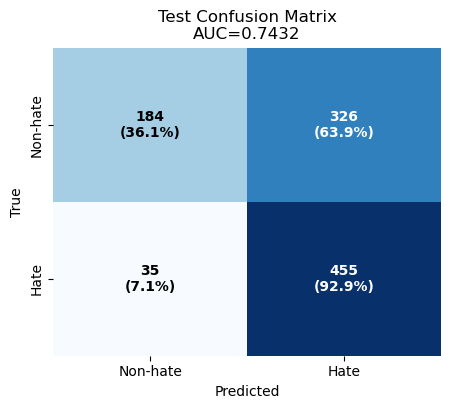

In [19]:
model.load_state_dict(torch.load('best_model.pt'))
probs_test, y_test = get_preds(test_loader)
y_pred = (probs_test >= best_thresh).astype(int)
cm = confusion_matrix(y_test, y_pred)
cm_pct = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=False,
            xticklabels=['Non-hate','Hate'], yticklabels=['Non-hate','Hate'])
for i in range(2):
    for j in range(2):
        plt.text(j+.5, i+.5, f"{cm[i,j]}\n({cm_pct[i,j]:.1f}%)",
                 ha='center', va='center',
                 color='white' if cm[i,j] > cm.max()/2 else 'black', weight='bold')
plt.title(f'Test Confusion Matrix\nAUC={roc_auc_score(y_test, probs_test):.4f}')
plt.ylabel('True'); plt.xlabel('Predicted'); plt.show()

## Optional: ROC Curve Plotting

To visualize the classifier's discriminative power, we can plot the ROC curve.


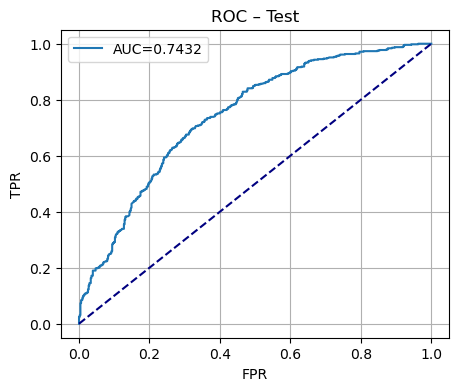

In [20]:
from sklearn.metrics import roc_curve, auc as auc_fn
def plot_roc(loader):
    probs, y = get_preds(loader)
    fpr, tpr, _ = roc_curve(y, probs)
    roc_auc = auc_fn(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
    plt.plot([0,1],[0,1],'--', color='navy')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC – Test"); plt.legend(); plt.grid(); plt.show()

plot_roc(test_loader)

## Optional Error Analysis  
Inspect top false positives & negatives to spot sarcasm, benign humor miscategorized, or under-represented hate tropes.

[Test Set] False Positives: 326
[Test Set] False Negatives: 35
False Positive: 70691.png | Score: 0.374


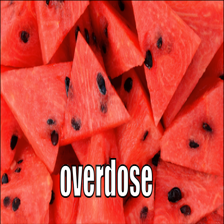

False Positive: 89263.png | Score: 0.378


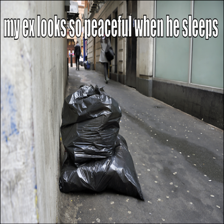

False Positive: 52971.png | Score: 0.408


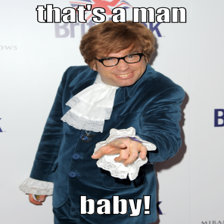

False Negative: 50162.png | Score: 0.334


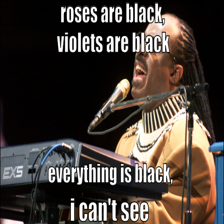

False Negative: 27980.png | Score: 0.339


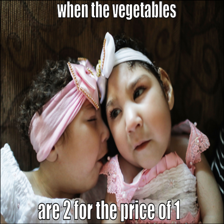

False Negative: 64735.png | Score: 0.304


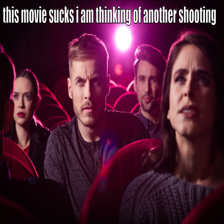

In [21]:
import os
from PIL import Image
from torch.utils.data import DataLoader
from IPython.display import display   # for notebook

def analyze_errors(model, df, dataset, threshold=0.5):
    """
    Explore false positives / negatives.
    threshold – cut-off used for binary decision
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    false_positives, false_negatives = [], []

    with torch.no_grad():
        for i, (feats, label) in enumerate(loader):
            feats  = feats.to(device).float()
            prob   = torch.sigmoid(model(feats)).item()
            pred   = prob > threshold
            true   = bool(label.item())

            if pred != true:
                meme_path = os.path.join(DATA_ROOT, 'img', os.path.basename(df.iloc[i]['img']))
                (false_positives if pred else false_negatives).append((meme_path, prob))

    print(f"[Test Set] False Positives: {len(false_positives)}")
    print(f"[Test Set] False Negatives: {len(false_negatives)}")

    def show_examples(examples, title):
        for path, prob in examples[:3]:
            print(f"{title}: {os.path.basename(path)} | Score: {prob:.3f}")
            display(Image.open(path).resize((224, 224)))

    show_examples(false_positives, "False Positive")
    show_examples(false_negatives, "False Negative")

# call after training / loading best checkpoint
analyze_errors(model, test_df, test_ds, threshold=best_thresh)

##  Optional Prompt Ablation Study  
Systematically drop entire hate-categories (groups of 9 prompts) and retrain from scratch.  
Quantify **which concepts are indispensable** and which are redundant.

In [22]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# helper: build datasets with ablated prompt embeddings
# ------------------------------------------------------------
def build_ablated_datasets(text_features_ablated):
    class AblatedMemeDataset(MemeDataset):
        def __init__(self, df):
            super().__init__(df)          # inherit __len__ & paths
            self.ablated_text_features = text_features_ablated

        def __getitem__(self, idx):
            row      = self.df.iloc[idx]
            img_path = f"{self.img_dir}/{os.path.basename(row['img'])}"
            label    = torch.tensor(row['label'], dtype=torch.float32)

            image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
            with torch.no_grad():
                img_feat = clip_model.encode_image(image)
                img_feat /= img_feat.norm(dim=-1, keepdim=True)
                sims = (img_feat @ self.ablated_text_features.T).squeeze(0)
                cat_sims = torch.stack([
                    sims[i*self.n_tmp:(i+1)*self.n_tmp].max()
                    for i in range(self.n_cat)
                ])
                feats = torch.cat([img_feat.squeeze(0), cat_sims])
            return feats, label

    train_ds_a = AblatedMemeDataset(train_df)
    val_ds_a   = AblatedMemeDataset(val_df)
    test_ds_a  = AblatedMemeDataset(test_df)

    return (DataLoader(train_ds_a, BATCH_SIZE, shuffle=True),
            DataLoader(val_ds_a,   BATCH_SIZE),
            DataLoader(test_ds_a,  BATCH_SIZE))

# ------------------------------------------------------------
# single ablation run
# ------------------------------------------------------------
def run_ablation_once(drop_indices, n_epochs=12):
    ablated = text_features.clone()
    for idx in drop_indices:
        start = idx * len(PROMPT_TEMPLATES)
        ablated[start: start + len(PROMPT_TEMPLATES)] = 0.0

    tr_loader, val_loader, test_loader = build_ablated_datasets(ablated)

    model = HateClassifier().to(device)
    crit  = FocalLoss(alpha=best['alpha'], gamma=best['gamma'])
    opt   = torch.optim.AdamW(model.parameters(), lr=best['lr_main'], weight_decay=best['wd'])
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=.5, patience=2)

    best_auc_run = 0.0
    for epoch in range(n_epochs):
        # ---- train ----
        model.train()
        epoch_loss = 0.0
        for x, y in tr_loader:
            opt.zero_grad()
            loss = crit(model(x.float()), y.unsqueeze(1))
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        epoch_loss /= len(tr_loader)

        # ---- validate ----
        model.eval()
        preds, labels = [], []
        with torch.no_grad():
            for x, y in val_loader:
                preds.extend(torch.sigmoid(model(x.float())).cpu().numpy().squeeze())
                labels.extend(y.cpu().numpy())
        auc = roc_auc_score(labels, preds)
        sched.step(auc)
        if auc > best_auc_run:
            best_auc_run = auc
            torch.save(model.state_dict(), 'tmp_abl.pt')

    # -- threshold on validation set --
    model.load_state_dict(torch.load('tmp_abl.pt'))
    val_probs, val_y = [], []
    with torch.no_grad():
        for x, y in val_loader:
            val_probs.extend(torch.sigmoid(model(x.float())).cpu().numpy().squeeze())
            val_y.extend(y.cpu().numpy())
    prec, rec, ths = precision_recall_curve(val_y, val_probs)
    thr = ths[np.argmax(2*prec*rec/(prec+rec+1e-8))]

    # -- test metrics --
    probs_test, y_test = [], []
    with torch.no_grad():
        for x, y in test_loader:
            probs_test.extend(torch.sigmoid(model(x.float())).cpu().numpy().squeeze())
            y_test.extend(y.cpu().numpy())
    y_pred = (np.array(probs_test) >= thr).astype(int)

    return {
        'AUC' : roc_auc_score(y_test, probs_test),
        'Acc' : accuracy_score(y_test, y_pred),
        'F1'  : f1_score(y_test, y_pred)
    }

# ------------------------------------------------------------
# sweep
# ------------------------------------------------------------
drop_sets = [
    [0],
    [0, 3, 7],
    [1, 2, 5],
    [10, 11, 12],
    [20, 21],
    list(range(5))
]

ablation_results = []
for drop_indices in drop_sets:
    print("\n" + "="*50)
    print(f"Ablation – dropping categories {drop_indices}")
    metrics = run_ablation_once(drop_indices)
    metrics['Dropped Indices'] = drop_indices
    ablation_results.append(metrics)
    print("Test metrics →", metrics)

# pretty table
abl_df = pd.DataFrame(ablation_results).sort_values("AUC", ascending=False)
display(abl_df)


Ablation – dropping categories [0]
Test metrics → {'AUC': 0.7343077230892356, 'Acc': 0.662, 'F1': 0.7130730050933786, 'Dropped Indices': [0]}

Ablation – dropping categories [0, 3, 7]
Test metrics → {'AUC': 0.7181932773109243, 'Acc': 0.637, 'F1': 0.6992543496271747, 'Dropped Indices': [0, 3, 7]}

Ablation – dropping categories [1, 2, 5]
Test metrics → {'AUC': 0.7189815926370546, 'Acc': 0.616, 'F1': 0.6966824644549762, 'Dropped Indices': [1, 2, 5]}

Ablation – dropping categories [10, 11, 12]
Test metrics → {'AUC': 0.7184553821528611, 'Acc': 0.656, 'F1': 0.6966490299823632, 'Dropped Indices': [10, 11, 12]}

Ablation – dropping categories [20, 21]
Test metrics → {'AUC': 0.727641056422569, 'Acc': 0.637, 'F1': 0.7060728744939271, 'Dropped Indices': [20, 21]}

Ablation – dropping categories [0, 1, 2, 3, 4]
Test metrics → {'AUC': 0.7262765106042417, 'Acc': 0.652, 'F1': 0.7035775127768313, 'Dropped Indices': [0, 1, 2, 3, 4]}


,AUC,Acc,F1,Dropped Indices
0,0.734308,0.662,0.713073,[0]
4,0.727641,0.637,0.706073,"[20, 21]"
5,0.726277,0.652,0.703578,"[0, 1, 2, 3, 4]"
2,0.718982,0.616,0.696682,"[1, 2, 5]"
3,0.718455,0.656,0.696649,"[10, 11, 12]"
1,0.718193,0.637,0.699254,"[0, 3, 7]"
